<a href="https://colab.research.google.com/github/BeniaminK/zum1/blob/main/RozpoznawanieMowy_rozwi%C4%85zanie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rozpoznawanie mowy

In [ ]:
%rm -r /content/*

In [ ]:
!wget https://github.com/danijel3/ASRforNLP/releases/download/v1.0/kaldi.tar.xz

!tar xvf kaldi.tar.xz -C / > /dev/null
%rm kaldi.tar.xz

!for f in $(find /opt/kaldi -name *.so*) ; do ln -sf $f /usr/local/lib/$(basename $f) ; done
!for f in $(find /opt/kaldi/src -not -name *.so* -type f -executable) ; do ln -s $f /usr/local/bin/$(basename $f) ; done
!for f in $(find /opt/kaldi/tools -not -name *.so* -type f -executable) ; do ln -s $f /usr/local/bin/$(basename $f) ; done

!ldconfig

Następnie ściągniemy przykładowe nagrania i zbiór tekstów do trenowania modelu języka.

In [ ]:
!wget https://github.com/BeniaminK/zum1/releases/download/v0.0.3/dzieci-text
!wget https://github.com/BeniaminK/zum1/releases/download/v0.0.3/dzieci-audio.zip

!unzip -o dzieci-audio.zip
%rm dzieci-audio.zip

Możemy obejrzeć, że katalog zawiera zestaw plików w formacie WAV i plik `text` zawierający referencyjną transkrypcję wszystkich nagrań:

In [ ]:
!head -n 10 dzieci-text
%ls dzieci-audio
%cat dzieci-audio/text

Następnie dokonamy odsłuchu plików w katalogu `sejm-audio`:

In [ ]:
from IPython.display import Audio
Audio('dzieci-audio/BenKal-01-01.wav')

Następnie pobierzemy wytrenowany model akustyczny i model do tranksrypcji fonetycznej.

In [ ]:
!wget https://github.com/danijel3/ASRforNLP/releases/download/v1.2/models.tar.xz

!tar xvf models.tar.xz > /dev/null

%rm models.tar.xz

## Wprowadzenie do WFST

Użyj następującego polecenia żeby zainstalować bibliotekę:

```
!pip install openfst-python
```

In [ ]:
!pip install openfst-python

import openfst_python as fst

**Zanim** przejdziemy do dalszych prac, stwórzmy sobie nowy katalog w którym będą generowane tymczasowe pliki,np. *grammar* poleceniem `%mkdir` i wejdź do niego przez `%cd`. Potem dodaj też odnośniki do katalogów `../phonetisaurus`, `../online` oraz `../sejm-audio` poleceniem `!ln -s`:

In [ ]:
%rm -r /content/grammar
%mkdir /content/grammar
%cd /content/grammar
!ln -s ../phonetisaurus
!ln -s ../online
!ln -s ../dzieci-audio
!ln -s ../text-dzieci

rm: cannot remove '/content/grammar': No such file or directory
/content/grammar


### Przygotowanie transkrypcji fonetycznej słów

Pierwszy automat jaki utworzymy będzie służył do konwersji słów na fonemy. Nazwiemy go **L.fst**. Tworzymy go w pierwszej kolejności, bo jest istotne  żebyśmy używali tej samej tablicy słów (identyfikatowów liczbowych) zarówno w leksykonie jak i gramatyce poniżej. Żeby ułatwić ten proces, użyjemy gotowej funkcji. Ściągnij plik https://raw.githubusercontent.com/danijel3/ASRforNLP/main/lexicon.py poleceniem `!wget` i zaimportuj funkcję `words_to_lexicon` z niego:

In [ ]:
!wget https://raw.githubusercontent.com/danijel3/ASRforNLP/main/lexicon.py
from lexicon import words_to_lexicon

--2022-01-24 16:34:55--  https://raw.githubusercontent.com/danijel3/ASRforNLP/main/lexicon.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13044 (13K) [text/plain]
Saving to: ‘lexicon.py’

lexicon.py          100%[===================>]  12.74K  --.-KB/s    in 0s      

2022-01-24 16:34:55 (98.1 MB/s) - ‘lexicon.py’ saved [13044/13044]



## Podejście oparte o statystyczny model języka

Utowrzymy najpierw katalog do przechowywania wszystkich plików tymczasowych. Zrób katalog `/content/lm` i przejdź do niego, a potem dodaj odnośniki do katalogów `../phonetisaurus`, `../online`, `../sejm-audio` oraz pliku `../sejm-text`:

In [ ]:
%cd /content
%mkdir lm
%cd lm
!ln -s ../phonetisaurus
!ln -s ../online
!ln -s ../dzieci-audio
!ln -s ../dzieci-text

/content
/content/lm


### Podstawy modelu n-gramowego

Model języka jest trenowany na zbiorze przykładowych zdań. 

Żeby wygenerować model języka, użyjemy programu z pakietu [SRILM](http://www.speech.sri.com/projects/srilm/). Nie jest to jedyne narzędzie do trenowania modeli języka, ale ma bardzo bogatą historię i mnóstwo zaimplementowanych mechanizmów. Inne narzędzia o tych samych zastosowania są przykładowo: MITLM, IRSTLM, KenLM, PocoLM.

Program `ngram-count` bierze następujące parametry:
* `-text test.txt` określa plik z źródłem danych
* `-order 3` mówi o rzędzie modelu - w tym przypadku jest to model trigramowy
* `-wbdiscount` to metoda umożliwiająca modelowi radzenie sobie z danymi nie występującymi w danych treningowych - jest kilka alternatywych metod, ale Witten-Bell jest optymalny dla bardzo małych zbiorów danych
* `-lm out.arpa` określa plik wynikowy

In [ ]:
!ngram-count -text dzieci-text -order 3 -wbdiscount -lm out.arpa -write-vocab word.list 
!ngram-count -text dzieci-text -order 3 -wbdiscount -lm out.arpa.gz -write-vocab word.list 

Plik ARPA jest formatem tekstowym i można łatwo odczytać jego zawartość. Użyj polecenia `%cat out.arpa` żeby go wyświetlić:

In [ ]:
%cat out.arpa


\data\
ngram 1=92
ngram 2=128
ngram 3=1

\1-grams:
-1.179935	</s>
-99	<s>	-0.3097427
-2.054996	a	-0.2854482
-2.054996	aby	-0.2971866
-1.878905	ale	-0.2854482
-1.878905	bardzo	-0.293309
-2.054996	błądzić	-0.2913571
-2.054996	całe	-0.2971866
-2.054996	całkowicie	-0.2971866
-2.054996	cały	-0.2971866
-2.054996	chodzącym	-0.2971866
-2.054996	cierpliwy	-0.27134
-2.054996	cię	-0.2952521
-2.054996	cudem	-0.2971866
-2.054996	czwórkę	-0.2854482
-2.054996	człowieka	-0.27134
-1.878905	do	-0.293309
-2.054996	dorośli	-0.2952521
-2.054996	dowiedzieć	-0.2971866
-1.452936	dzieci	-0.2807963
-2.054996	dzieciom	-0.2971866
-2.054996	dzieciństwo	-0.2913571
-2.054996	dzieckiem	-0.2971866
-1.577875	dziecko	-0.3265704
-2.054996	dążyć	-0.2952521
-2.054996	gdzie	-0.2971866
-1.657056	i	-0.2854482
-2.054996	ich	-0.2971866
-2.054996	istota	-0.2971866
-2.054996	jak	-0.2952521
-2.054996	jedynym	-0.2971866
-1.878905	jest	-0.293309
-2.054996	jesteś	-0.2971866
-1.878905	kiedy	-0.2913571
-2.054996	kochać	-0.2971866
-2.0

Składa się on z nagłówka zaczynającego od tokenu `/data/` i zawierającego liczność poszczególnych n-gramów. Potem mamy kolejne sekcje, każda zawierająca listę poszczególnych n-gramów.

Każdy n-gram jest opisany dwoma lub trzema polami oddzielonymi znakami `\t`:
* prawdopodobieństwo danego n-gramu w skali logarytmicznej
* opis samego n-gramu (tokeny/słowa oddzielone spacją)
* opcjonalnie tzw. "*back-off weight*" też w skali log

Back-off jest metodą do określenia prawdopodobieństwa n-gramów wyższego stopnia użwyając n-gramów niższego. Z tego powodu, najwyższe n-gramy (w naszym przypadku 3-gramy) nie mają policzonych wag back-off. Algorytm liczenia prawdopodonieństwa n-gramu jest następujący:

* jeśli na liście jest dokładnie ten n-gram którego szukamy, bierzemy jego prawdopodobieństwo
* jeśli go nie ma liście, bierzemy prawdopodobieństwo według wzoru:

\begin{equation}
P( word_N | word_{N-1}, word_{N-2}, ...., word_1 ) = \\
P( word_N | word_{N-1}, word_{N-2}, ...., word_2 ) \cdot \text{backoff-weight}(  word_{N-1} | word_{N-2}, ...., word_1 )
\end{equation}

* jeśli brakuje prawdopodobieństwa n-gramu mniejszego stopnia, wtedy rekurencyjnie stosujemy ten sam wzór aż do unigramów (które wszystkie powinny być zdefiniowane)
* jeśli brakuje wagi back-off, zakładmy wartość 1 (czyli 0 w skali logarytmicznej)

Na przykład, prawdopodobieństwo n-gramu "*ala ma*" jest następujące:

\begin{equation}
P(ma|ala) = 10^{-0.1760913} = 0.6666666038148176
\end{equation}

A prawdopodobieństwo n-gramu "*jan ma psa*":


\begin{equation}
P(psa|jan,ma) = P(psa|ma)*bwt(ma|jan)=10^{(-0.69897+0)}=0.20000000199681048
\end{equation}

Użyjmy prostej biblioteki `arpa` żeby potwierdzić powyższe obliczenia. Dokumentacja do biblioteki jest [tutaj](https://pypi.org/project/arpa/). Zainstaluj bibliotekę `arpa` poleceniem `!pip install`, a potem ją zaimportuj. Funkcja `arpa.loadf()` służy do wczytania modelu. Funkcja ta zwraca listę (standard ARPA widocznie wspiera więcej modeli w jednym pliku), więc należy odczytać pierwszy element z wynikowej listy. Potem w tym modelu można użyć funkcji `.p()` żeby odczytać prawdopodobieństwo n-gramu  lub funkcję `.s()` żeby odczytać sumaryczne prawdopodobieństwo zdania. Są też odpowiednie funkcje w skali logarytmicznej (wskazane dla dłuższych tekstów):

In [ ]:
!pip install arpa
import arpa

lm=arpa.loadf('out.arpa')[0]

print(lm.p('dzieci są ludzie'))
print(lm.p('dzieci są ojcem'))

0.4999999950079739
0.004444443606419831


Jedną z podstatowych miar jakości modelu języka to tzw. *perplexity*. Liczymy go stotując wytrenowany model języka na niezależnym zbiorze testowym. Zróbmy przykładowy zbiór zawierający jedno zdanie (np. *ala ma osę*) i zapiszmy w pliku `eval.txt`:

In [ ]:
%%writefile eval.txt
dzieci nigdy nie słuchają starszych ale zawsze ich naśladują

Writing eval.txt


Do wyliczenia perplexity użyjemy programu `ngram` i użyjemy w nim opcję `-lm out.arpa` do wczytania pliku z modelem oraz `-ppl eval.txt` żeby policzyć perplexity na wybranym pliku:

In [ ]:
!ngram -lm out.arpa -ppl eval.txt

file eval.txt: 1 sentences, 9 words, 0 OOVs
0 zeroprobs, logprob= -5.981575 ppl= 3.964218 ppl1= 4.619761


Wyniki zawierają ilość zdań, słów i wyrazów spoza słownika (OOV - out-of-vocabulary). Zawiera też wyliczony logprob całego korpusu oraz perplexity wyczlione uwzględniając (`ppl1`) i nieuwzlgędniając (`ppl`) sztucznie dodane tokeny `<s>` oraz `</s>`. Im mniejsza wartość PPL, tym model lepiej opisuje testowy zbiór tekstów.

Program `ngram` ma mnóstwo zastosowań, głównie związanych z edycją i manipulacją wytrenowanego modelu języka. Ma też opcję `-gen <N>` do wygenerowania losowych zdań z konkretnego modelu języka. Użyj go żeby wygenerować 10 losowych zdań:

In [ ]:
!ngram -lm out.arpa -gen 10

nie niż poprawy zawsze wiele są ludzie
dziecko to mogły kochać twoje dzieci mogły dążyć kochać nigdy nie do niezastąpionym
matką pozwól dzieci najuważniej czwórkę objaśniania jedynym nie do nich
dorośli nigdy między śmieje dowiedzieć na przykład jak błądzić dowiedzieć pozostań dzieckiem wychować czwórkę słuchają pozostań naśladują cały świat
zrozumieć a
dorośli czwórkę dzieci nie na przykład nich dziecko to przecinek między ojcem się przez całe słuchają starszych świat dzieci dzieci zrozumieć a mieszka pięciu lat i spójnik
się ma
dziecko się wiele dowiedzieć się ma zawsze dzieci można się dziecko poniżej się przez taki chodzącym cudem jedynym wyjątkowym i lat to przecinek między niezastąpionym
dzieci życie można ale kiedy dzieciom a dzieci całkowicie szalona
mogły przecinek i spójnik sami radośnie nich objaśniania


Użyjmy teraz narzędzia `arpa2fst` do wygenerowania transducera odpowiadającego powyższemu modelu języka:

In [ ]:
!arpa2fst out.arpa out.fst

arpa2fst out.arpa out.fst 
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:94) Reading \data\ section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \1-grams: section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \2-grams: section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \3-grams: section.


Użyjmy naszej bibliotegko OpenFST do wczytania (metodą `fst.FST.read()`) i narysowania grafu modelu:

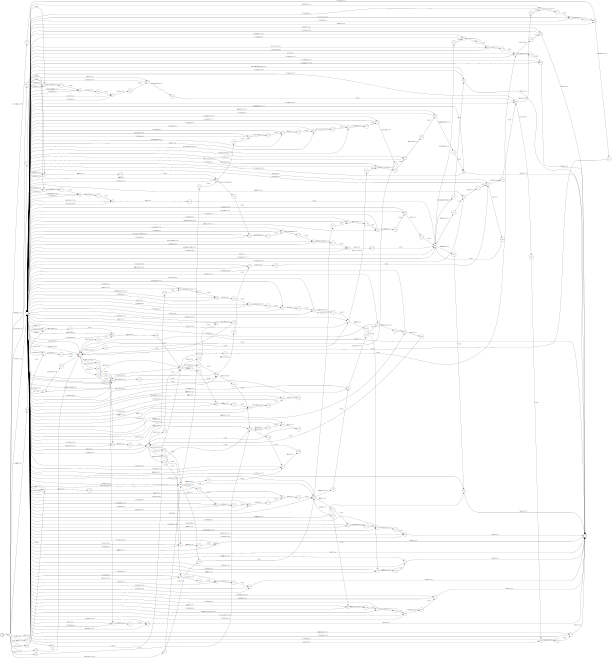

In [ ]:
G=fst.Fst.read('out.fst')
G

In [ ]:
!cut -f2- -d' ' dzieci-audio/text > eval.txt
!ngram -unk -lm out.arpa.gz -ppl eval.txt

file eval.txt: 14 sentences, 122 words, 0 OOVs
0 zeroprobs, logprob= -75.08056 ppl= 3.565028 ppl1= 4.12491


### Utworzenie trankrypcji fonetycznej

Zaczniemy więc od stworzwnia leksykonu do nowego modelu języka. Wczytajmy listę słów z pliku `word.list`, ale przskoczymy niektóre specjalne słowa których nie chcemy mieć w leksykonie (`-pau-`, `<unk>`, `<s>`, `</s>`):

In [ ]:
words=[]
with open('word.list') as f:
  for l in f:
    w=l.strip()
    if w!='-pau-' and w[0]!='<':
      words.append(w)
psyms,wsyms,L=words_to_lexicon(words)

In [ ]:
!wc -l word.list

94 word.list


Zapiszmy tym razem leksykon do pliku `L.fst` na dysku:

In [ ]:
L.set_input_symbols(psyms)
L.set_output_symbols(wsyms)
L.write('L.fst')

Żeby ułatwić proces deteriminizacji później, dodamy pętle do specjalnych tokenów dysambiguacyjnychm zarówno po stronie fonemów, jak i słów. Najpierw musimy znaleźć liczby reprezentujące te tokeny (występujące pod nazwą `#0` w listach symboli - można do tego użyć programu `grep` na plikach `phones.txt` i `words.txt`), a potem użyjemy programu `fstaddselfloops`. Dodatkowo możemy posortować przejścia programem `fstarcsort` ustawiając parametr `--sort_type=olabel` i wynik zapiszemy w pliku `L_disambig.fst`:

In [ ]:
!grep '#0' phones.txt | cut -f2 -d' ' > wdisambig_phones.int
!grep '#0' words.txt | cut -f2 -d' ' > wdisambig_words.int
!fstaddselfloops wdisambig_phones.int wdisambig_words.int < L.fst | fstarcsort --sort_type=olabel > L_disambig.fst

fstaddselfloops wdisambig_phones.int wdisambig_words.int 


### Budowa grafu WFST

Użyjmy teraz program `arpa2fst` żeby wygenerować automat `G.fst`. Dodamy do programu parametr `--disambig-symbol="#0"` oraz wczytamy listę symboli z pliku `--read-symbol-table=words.txt`:

In [ ]:
!gunzip -c out.arpa.gz | arpa2fst --disambig-symbol="#0" --read-symbol-table=words.txt - G.fst

arpa2fst --disambig-symbol=#0 --read-symbol-table=words.txt - G.fst 
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:94) Reading \data\ section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \1-grams: section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \2-grams: section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \3-grams: section.
LOG (arpa2fst[5.5.971~1-07043]:RemoveRedundantStates():arpa-lm-compiler.cc:359) Reduced num-states from 207 to 93


Teraz możemy dokonać kompozycji `L_disambig.fst` i `G.fst`, a potem zastosować determinizacje programem `fstdeterminizestar` ustawiając `--use-log=true` i minimalizacje programem `fstminimizeencoded`. Dodatkowo możemy użyć operacji przesuwania symboli programem `fstpushspecial`, żeby dodatkowo zoptymalizować działanie automatu:

In [ ]:
!fsttablecompose L_disambig.fst G.fst | fstdeterminizestar --use-log=true | fstminimizeencoded | fstpushspecial > LG.fst

fstminimizeencoded 
fsttablecompose L_disambig.fst G.fst 
fstpushspecial 
fstdeterminizestar --use-log=true 


Tak jak poprzednio, dodajemy kontekst żeby utworzyć automat `CLG.fst`:

In [ ]:
!fstcomposecontext --context-size=2 --central-position=1 --read-disambig-syms=disambig.int --write-disambig-syms=disambig_ilabels.int ilabels LG.fst | fstarcsort --sort_type=ilabel > CLG.fst

fstcomposecontext --context-size=2 --central-position=1 --read-disambig-syms=disambig.int --write-disambig-syms=disambig_ilabels.int ilabels LG.fst 


Generujemy automat `H.fst`:

In [ ]:
!make-h-transducer --disambig-syms-out=disambig_tid.int --transition-scale=1.0 ilabels online/tree online/final.mdl H.fst

make-h-transducer --disambig-syms-out=disambig_tid.int --transition-scale=1.0 ilabels online/tree online/final.mdl H.fst 


I dokonujemy ostatecznej kompozycji żeby utworzyć finalny model `HCLG.fst`:

In [ ]:
!fsttablecompose H.fst CLG.fst - | fstdeterminizestar --use-log=true - - | fstrmsymbols disambig_tid.int - - | fstminimizeencoded - - | add-self-loops --self-loop-scale=0.1 --reorder=true online/final.mdl - HCLG.fst

add-self-loops --self-loop-scale=0.1 --reorder=true online/final.mdl - HCLG.fst 
fstrmsymbols disambig_tid.int - - 
fstdeterminizestar --use-log=true - - 
fstminimizeencoded - - 
fsttablecompose H.fst CLG.fst - 


Warto zwrócic uwagę na rozmiar automatu poleceniem `%ls -lh`. Jest on znacznie większy niż poprzedni automat oparty na ręcznie napisanej gramatyce. Jest też znacznie większy niż model ARPA. Warto wziąć pod uwagę, że automat HCLG.fst będzie w bardzo przybliżonym rozmiarze wczytany do pamięci RAM podczas rozpoznawania mowy. W prkatycznych zastosowaniach (ze słownikami kilkudzisięciu-klikuset tysięcy słów) ten model zajmuje największy udział w pamięci procesu rozpoznawania mowy (kilkaset MB do kilka GB):

In [ ]:
%ls -lh

total 312K
-rw-r--r-- 1 root root  34K Jan 24 16:35 CLG.fst
-rw-r--r-- 1 root root    2 Jan 24 16:35 disambig_ilabels.int
-rw-r--r-- 1 root root    8 Jan 24 16:35 disambig.int
-rw-r--r-- 1 root root    6 Jan 24 16:35 disambig_tid.int
lrwxrwxrwx 1 root root   15 Jan 24 16:34 dzieci-audio -> ../dzieci-audio/
lrwxrwxrwx 1 root root   14 Jan 24 16:34 dzieci-text -> ../dzieci-text
-rw-r--r-- 1 root root  875 Jan 24 16:35 eval.txt
-rw-r--r-- 1 root root 5.9K Jan 24 16:35 G.fst
-rw-r--r-- 1 root root  75K Jan 24 16:35 HCLG.fst
-rw-r--r-- 1 root root  39K Jan 24 16:35 H.fst
-rw-r--r-- 1 root root  13K Jan 24 16:35 ilabels
-rw-r--r-- 1 root root  19K Jan 24 16:35 L_disambig.fst
-rw-r--r-- 1 root root  19K Jan 24 16:35 L.fst
-rw-r--r-- 1 root root  25K Jan 24 16:35 LG.fst
lrwxrwxrwx 1 root root    9 Jan 24 16:34 online -> ../online/
-rw-r--r-- 1 root root 5.6K Jan 24 16:34 out.arpa
-rw-r--r-- 1 root root 1.6K Jan 24 16:34 out.arpa.gz
-rw-r--r-- 1 root root  13K Jan 24 16:35 out.fst
-rw-r--r-- 1 

### Rozpoznawanie mowy

Podobnie jak wyżej, zróbmy listy plików `wav.scp` i `spk2utt`, ale tym razem uwzględnijmy cały katalog `sejm-audio`:

In [ ]:
%%bash
for f in dzieci-audio/*.wav ; do echo $(basename $f .wav) $(readlink -f $f) ; done > wav.scp
cut -f1 -d' ' wav.scp | awk '{print $1, $1}' > spk2utt

Podobnie jak wyżej, użyjemy `!online2-wav-nnet3-latgen-faster` do rozpoznawania:

In [ ]:
!online2-wav-nnet3-latgen-faster --word-symbol-table=words.txt --config=online/conf/online.conf online/final.mdl HCLG.fst ark:spk2utt scp:wav.scp ark:lat

online2-wav-nnet3-latgen-faster --word-symbol-table=words.txt --config=online/conf/online.conf online/final.mdl HCLG.fst ark:spk2utt scp:wav.scp ark:lat 
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:CompileLooped():nnet-compile-looped.cc:345) Spent 0.00891805 seconds in looped compilation.
BenKal-01-01 od dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cier

### Sprawdzenie wyników

Tak jak wcześniej, wygnerujmy listy wyników:

In [ ]:
!lattice-best-path ark:lat ark,t:- | /opt/kaldi/egs/wsj/s5/utils/int2sym.pl -f 2- words.txt > trans.txt

lattice-best-path ark:lat ark,t:- 
LOG (lattice-best-path[5.5.971~1-07043]:main():lattice-best-path.cc:99) For utterance BenKal-01-01, best cost 38.6959 + -406.715 = -368.019 over 202 frames.
LOG (lattice-best-path[5.5.971~1-07043]:main():lattice-best-path.cc:99) For utterance BenKal-02-01, best cost 21.6188 + -266.865 = -245.247 over 109 frames.
LOG (lattice-best-path[5.5.971~1-07043]:main():lattice-best-path.cc:99) For utterance BenKal-03-01, best cost 24.9562 + -364.068 = -339.111 over 176 frames.
LOG (lattice-best-path[5.5.971~1-07043]:main():lattice-best-path.cc:99) For utterance BenKal-04-01, best cost 31.9005 + -391.801 = -359.9 over 181 frames.
LOG (lattice-best-path[5.5.971~1-07043]:main():lattice-best-path.cc:99) For utterance BenKal-05-01, best cost 32.1585 + -479.187 = -447.028 over 215 frames.
LOG (lattice-best-path[5.5.971~1-07043]:main():lattice-best-path.cc:99) For utterance BenKal-06-01, best cost 31.795 + -387.38 = -355.585 over 181 frames.
LOG (lattice-best-path[5.5.

I sprawdźmy co zostało rozpoznane poleceniem `%cat trans.txt`:

In [ ]:
%cat trans.txt

BenKal-01-01 od dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-02-01 nie ma dzieci są ludzie 
BenKal-03-01 dziecko to taki sympatyczny początek człowieka 
BenKal-04-01 dzieciństwo to miejsce gdzie mieszka się przez całe życie 
BenKal-05-01 dziecko jest chodzącym cudem jedynym wyjątkowym i niezastąpionym 
BenKal-06-01 dzieci słuchają starszych ale zawsze ich naśladują 
BenKal-07-01 dziecko to przecinek między ojcem i matką ale i spójnik 
BenKal-08-01 pozwól dzieciom błądzić i radośnie dążyć do poprawy 
BenKal-09-01 dziecko poniżej pięciu lat to istota całkowicie szalona 
BenKal-10-01 pozostań dzieckiem aby cię zawsze mogły kochać twoje dzieci 
BenKal-11-01 dzieci najuważniej słuchają kiedy mówi się nie do nich 
BenKal-12-01 kiedy śmieje się dziecko śmieje się cały świat 
BenKal-13-01 prościej jest rządzić narodem niż wychować czwórkę dzieci 
BenKal-14-01 dorośli nigdy nie potrafią sami zrozumieć a dzieci bardzo męczy konieczność stałego objaśniania 


Policzmy WER:

In [ ]:
!compute-wer ark:dzieci-audio/text ark:trans.txt

compute-wer ark:dzieci-audio/text ark:trans.txt 
%WER 1.64 [ 2 / 122, 0 ins, 2 del, 0 sub ]
%SER 7.14 [ 1 / 14 ]
Scored 14 sentences, 0 not present in hyp.


Możemy też użyc program `align-text` i skryptu `/opt/kaldi/egs/wsj/s5/utils/scoring/wer_per_utt_details.pl` żeby dostać dokładny opis błędów:

In [ ]:
!align-text ark:dzieci-audio/text ark:trans.txt ark:- | /opt/kaldi/egs/wsj/s5/utils/scoring/wer_per_utt_details.pl

align-text ark:dzieci-audio/text ark:trans.txt ark:- 
LOG (align-text[5.5.971~1-07043]:main():align-text.cc:135) Done 14 sentences, failed for 0
/opt/kaldi/egs/wsj/s5/utils/scoring/wer_per_utt_details.pl: Note: handling as utf-8 text
BenKal-01-01 ref  od  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 hyp  od  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 op    C     C      C     C     C         C       C      C      C      C       C        C    
BenKal-01-01 #csid 12 0 0 0
BenKal-02-01 ref  nie  ma  dzieci  są  ludzie
BenKal-02-01 hyp  nie  ma  dzieci  są  ludzie
BenKal-02-01 op    C    C     C     C     C  
BenKal-02-01 #csid 5 0 0 0
BenKal-03-01 ref  dziecko  to  taki  sympatyczny  początek  człowieka
BenKal-03-01 hyp  dziecko  to  taki  sympatyczny  początek  człowieka
BenKal-03-01 op      C      C    C        C           C         C    
BenKal-03-01 #csid 6 0 0 0
BenKal-04-01 ref  

Wróćmy jednak do pojęcia kraty - krata to połączony graf zawierający wszystkie alternatywy procesu rozpoznawania mowy. Możemy ją obejrzeć jeśli skopiujemy jej zawartość do postaci tekstowej programem `lattice-copy` (zamieniając `ark:lat` na `ark,t:-`) i w wyniku zamienimy wartości w 3 kolumnie na wyrazy skryptem `int2sym.pl`:

In [ ]:
!lattice-copy ark:lat ark,t:- | /opt/kaldi/egs/wsj/s5/utils/int2sym.pl -f 3 words.txt 

lattice-copy ark:lat ark,t:- 
BenKal-01-01 
0 1 od 12.241,-118.522,2_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_7868_7867_7867 
0 2 dzieci 13.2291,-132.134,2_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_2792_2791_2791_2791_3740_3739_3739_11878_11877_11877_11877 
0 13 błądzić 14.5212,-119.725,2_1_1_1_1_1_1_1_1_1_1_1_1658_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_1657_13034_13033_8624_3202_4930_11758_2862_2861_2861_3740_3739_3739_11878_11877_11877 
0 14 i 13.4619,-94.3913,4880_2_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_7868_7867_7867_7867 
0 17 a 10.2099,-91.7122,1442_2_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1 
0 14 do 13.9912,-93.9807,2_1_1_1_1_1_1_1_1_1_1_1_2168_2167_2167_2167_2167_2167_2167_2167_2167_2167_2167_2167_2167_2167_21

Format tego pliku zawiera następujące kolumny:
* stan początkowy
* stan docelowy
* wyraz
* waga - definicja wagi jest:
  * waga modelu języka
  * waga modelu akustycznego
  * sekwencja stanów ukrytych (H) reprezentujących dany wyraz

Najlepsza sekwencja jest taka która ma najwyższą ocenę względem sumy (w skali log, czyli iloczynu normalnie) dwóch prawdopodobieństw (języka i akustyki).

Używając programu `lattice-to-fst` możemy uprościć kratę a potem poleceniem `sed -n '/AndrzejKania.*/,/^$/p' | tail -n +2)` wyciągnąć poojedynczą kratę oraz zamienić ją na FST programem `fstcompile` i wyświetlić podobnie do G.fst wyżej.

Ponieważ krata ta jest trochę duża, warto ją jednak zapisać do pliku poleceniem `lattice.draw('lattice.dot')` a potem użyć programu `dot -Tpng -Gdpi=1800 lattice.dot > lattice.png` żeby ją zapisać do pliku. Taki plik możemy ściągnąć z przeglądarki plików po lewej i obejrzeć lokalnie na komputerze.

Najlepsza ścieżka względem oceny modeli akustycznego i języka w każdej kracie generuje odpowiedź o określonym wyżej WER, ale to wcale nie oznacza, że jest ona najbardziej poprawna wzgledem prawdziwego nagrania. Gdybyśmy mieli wyrocznie, która nam podowiada jakie wyrazy bardziej pasują do prawdziwego nagrania, moglibyśmy w kracie znaleźć lepsze rozwiązanie. Program `lattice-oracle` służy do tego żeby ocenić tą potencjalną ocenę.

Warto zauważyć, że wynik ten można poprawić zmieniając parametry `--beam` i `--lattice-beam` w konfiguracji dekodera (plik `online/conf/online.conf`).


In [ ]:
%cat online/conf/online.conf

--feature-type=mfcc
--mfcc-config=online/conf/mfcc.conf
--ivector-extraction-config=online/conf/ivector_extractor.conf
--endpoint.silence-phones=1:2:3:4:5:6:7:8:9:10
--beam=10.0
--min-active=200 
--max-active=7000
--lattice-beam=7.0
--acoustic-scale=1.0
--frames-per-chunk=20
--frame-subsampling-factor=3
--extra-left-context-initial=0


In [ ]:
!lattice-oracle ark:lat ark,t:"/opt/kaldi/egs/wsj/s5/utils/sym2int.pl -f 2- words.txt < dzieci-audio/text|" ark:/dev/null

lattice-oracle ark:lat 'ark,t:/opt/kaldi/egs/wsj/s5/utils/sym2int.pl -f 2- words.txt < dzieci-audio/text|' ark:/dev/null 
Lattice BenKal-01-01 read.
LOG (lattice-oracle[5.5.971~1-07043]:main():lattice-oracle.cc:320) %WER 0 [ 0 / 12, 0 insertions, 0 deletions, 0 sub ]
LOG (lattice-oracle[5.5.971~1-07043]:main():lattice-oracle.cc:334) For utterance BenKal-01-01, best cost 0
Lattice BenKal-02-01 read.
LOG (lattice-oracle[5.5.971~1-07043]:main():lattice-oracle.cc:320) %WER 0 [ 0 / 5, 0 insertions, 0 deletions, 0 sub ]
LOG (lattice-oracle[5.5.971~1-07043]:main():lattice-oracle.cc:334) For utterance BenKal-02-01, best cost 0
Lattice BenKal-03-01 read.
LOG (lattice-oracle[5.5.971~1-07043]:main():lattice-oracle.cc:320) %WER 0 [ 0 / 6, 0 insertions, 0 deletions, 0 sub ]
LOG (lattice-oracle[5.5.971~1-07043]:main():lattice-oracle.cc:334) For utterance BenKal-03-01, best cost 0
Lattice BenKal-04-01 read.
LOG (lattice-oracle[5.5.971~1-07043]:main():lattice-oracle.cc:320) %WER 0 [ 0 / 9, 0 insertion

Zamiast kraty, możemy też pracować na listach N-best. To jest lista N najlepszych ścieżek w całej kracie. Używając programu `lattice-to-nbest` możemy wygenerować takie listy dla poszczególnych plików, a programem `nbest-to-linear` zamienić je na ciągi słów. Znowu, skrypt `int2sym.pl` się przydaje żeby zamienić liczby na słowa:

In [ ]:
!nbest-to-linear ark:1.nbest ark:1.ali ark,t:1.words ark:1.lmscore ark:1.acscore
!lattice-to-nbest --acoustic-scale=0.1 --n=10 ark:lat ark:1.nbest
!head 1.words

nbest-to-linear ark:1.nbest ark:1.ali ark,t:1.words ark:1.lmscore ark:1.acscore 
WARNING (nbest-to-linear[5.5.971~1-07043]:Open():util/kaldi-table-inl.h:513) Failed to open stream 1.nbest
ERROR (nbest-to-linear[5.5.971~1-07043]:SequentialTableReader():util/kaldi-table-inl.h:860) Error constructing TableReader: rspecifier is ark:1.nbest

[ Stack-Trace: ]
/opt/kaldi/src/lib/libkaldi-base.so(kaldi::MessageLogger::LogMessage() const+0xb42) [0x7fcd8f861722]
nbest-to-linear(kaldi::MessageLogger::LogAndThrow::operator=(kaldi::MessageLogger const&)+0x21) [0x561f77c2510b]
nbest-to-linear(kaldi::SequentialTableReader<kaldi::LatticeHolder>::SequentialTableReader(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&)+0xc2) [0x561f77c295ca]
nbest-to-linear(main+0x125) [0x561f77c2322f]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0xe7) [0x7fcd8e938bf7]
nbest-to-linear(_start+0x2a) [0x561f77c2302a]

kaldi::KaldiFatalErrorlattice-to-nbest --acoustic-scale=0.1 --n=

In [ ]:
!lattice-to-nbest --n=10 ark:lat ark:- | nbest-to-linear ark:- ark:/dev/null ark,t:- | /opt/kaldi/egs/wsj/s5/utils/int2sym.pl -f 2- words.txt  > result
!head result

nbest-to-linear ark:- ark:/dev/null ark,t:- 
lattice-to-nbest --n=10 ark:lat ark:- 
LOG (lattice-to-nbest[5.5.971~1-07043]:main():lattice-to-nbest.cc:125) Done applying N-best algorithm to 14 lattices with n = 10, average actual #paths is 8.21429
LOG (nbest-to-linear[5.5.971~1-07043]:main():nbest-to-linear.cc:89) Done 115 n-best entries, 0 had errors.
BenKal-01-01-1 od dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01-2 dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01-3 błądzić dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01-4 od dzieci można się wiele dowiedzieć na przykład jak bardzo 
BenKal-01-01-5 od dzieci można się wiele dowiedzieć na przykład jak bardzo cierpliwy 
BenKal-01-01-6 i od dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01-7 od dzieci można się się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-0

# Wizualizacja błędów (wyników programu wer_per_utt_details.pl)

In [ ]:
def transform_result_to_align_text(file_str):
  with open(file_str, 'r') as f:
    lines = f.readlines()
  with open(file_str + "_for_align", 'w') as f:
    for line in lines:
      import re
      new_line = re.sub('(BenKal-\d\d-\d\d)-\d+', '\\1', line)
      f.write(new_line)

transform_result_to_align_text('result')
    
!head result_for_align

BenKal-01-01 od dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01 dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01 błądzić dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01 od dzieci można się wiele dowiedzieć na przykład jak bardzo 
BenKal-01-01 od dzieci można się wiele dowiedzieć na przykład jak bardzo cierpliwy 
BenKal-01-01 i od dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01 od dzieci można się się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01 a dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01 do od dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy 
BenKal-01-01 dzieci można się wiele dowiedzieć na przykład jak bardzo 


In [ ]:
# align-test
! align-text ark:result_for_align ark:dzieci-audio/text ark,t:- | head


align-text ark:result_for_align ark:dzieci-audio/text ark,t:- 
LOG (align-text[5.5.971~1-07043]:main():align-text.cc:135) Done 115 sentences, failed for 0
BenKal-01-01 od od ; dzieci dzieci ; można można ; się się ; wiele wiele ; dowiedzieć dowiedzieć ; na na ; przykład przykład ; jak jak ; bardzo bardzo ; jesteś jesteś ; cierpliwy cierpliwy 
BenKal-01-01 <eps> od ; dzieci dzieci ; można można ; się się ; wiele wiele ; dowiedzieć dowiedzieć ; na na ; przykład przykład ; jak jak ; bardzo bardzo ; jesteś jesteś ; cierpliwy cierpliwy 
BenKal-01-01 błądzić od ; dzieci dzieci ; można można ; się się ; wiele wiele ; dowiedzieć dowiedzieć ; na na ; przykład przykład ; jak jak ; bardzo bardzo ; jesteś jesteś ; cierpliwy cierpliwy 
BenKal-01-01 od od ; dzieci dzieci ; można można ; się się ; wiele wiele ; dowiedzieć dowiedzieć ; na na ; przykład przykład ; jak jak ; bardzo bardzo ; <eps> jesteś ; <eps> cierpliwy 
BenKal-01-01 od od ; dzieci dzieci ; można można ; się się ; wiele wiele ; dowiedz

In [ ]:
# wer_per_utt-details
! align-text ark:result_for_align ark:dzieci-audio/text ark,t:- | /opt/kaldi/egs/wsj/s5/utils/scoring/wer_per_utt_details.pl > wer_per_utt
! head wer_per_utt

align-text ark:result_for_align ark:dzieci-audio/text ark,t:- 
LOG (align-text[5.5.971~1-07043]:main():align-text.cc:135) Done 115 sentences, failed for 0
/opt/kaldi/egs/wsj/s5/utils/scoring/wer_per_utt_details.pl: Note: handling as utf-8 text
BenKal-01-01 ref  od  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 hyp  od  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 op    C     C      C     C     C         C       C      C      C      C       C        C    
BenKal-01-01 #csid 12 0 0 0
BenKal-01-01 ref  <eps>  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 hyp    od   dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 op     I       C      C     C     C         C       C      C      C      C       C        C    
BenKal-01-01 #csid 11 0 1 0
BenKal-01-01 ref  błądzić  dzieci  można  się  wiele  d

In [ ]:
def calculate_wer(wer_file):
  import re
  from collections import defaultdict

  wer_per_utt = defaultdict(lambda: defaultdict(int))

  tot = defaultdict(int)

  with open(wer_file, 'r') as f:
    lines = f.readlines()
  for line in lines:
    m = re.search("(?P<utt>BenKal-\d\d-\d\d)\s+#csid\s+(?P<c>\d+) (?P<s>\d+) (?P<i>\d+) (?P<d>\d+)", line)

    if m:
      utt = m.group('utt')
      c, s, i, d = m.group('c'), m.group('s'), m.group('i'), m.group('d')
      tot['c'] += int(c)
      tot['s'] += int(s)
      tot['i'] += int(i)
      tot['d'] += int(d)

      wer_per_utt[utt]['c'] += int(c)
      wer_per_utt[utt]['s'] += int(s)
      wer_per_utt[utt]['i'] += int(i)
      wer_per_utt[utt]['d'] += int(d)
  
  utt_wer = {}
  for utt in wer_per_utt:
      wer_per_utt[utt]['c'] += int(c)
      wer_per_utt[utt]['s'] += int(s)
      wer_per_utt[utt]['i'] += int(i)
      wer_per_utt[utt]['d'] += int(d)

      errs = wer_per_utt[utt]['d'] + wer_per_utt[utt]['s'] + wer_per_utt[utt]['i'] + wer_per_utt[utt]['d']
      utt_wer[utt] = errs / (wer_per_utt[utt]['c'] + errs)

  tot_errs = tot['d'] + tot['s'] + tot['i'] + tot['d']
  return tot_errs / (tot['c'] + tot_errs), utt_wer
  
total_wer, wer_per_utt = calculate_wer('wer_per_utt')

print("Utterances:")

with open('dzieci-audio/text', 'r') as f:
  for line in f.readlines():
      print(f"Utterance: {line.strip()}")
      print(f"WER: {wer_per_utt[line.split()[0]]:.2%}\n")

print('=' * 20)
print(f"Total WER: {total_wer:.2%}")

Utterances:
Utterance: BenKal-01-01 od dzieci można się wiele dowiedzieć na przykład jak bardzo jesteś cierpliwy
WER: 12.23%

Utterance: BenKal-02-01 nie ma dzieci są ludzie
WER: 16.00%

Utterance: BenKal-03-01 dziecko to taki sympatyczny początek człowieka
WER: 23.46%

Utterance: BenKal-04-01 dzieciństwo to miejsce gdzie mieszka się przez całe życie
WER: 15.97%

Utterance: BenKal-05-01 dziecko jest chodzącym cudem jedynym wyjątkowym i niezastąpionym
WER: 20.18%

Utterance: BenKal-06-01 dzieci nigdy nie słuchają starszych ale zawsze ich naśladują
WER: 23.30%

Utterance: BenKal-07-01 dziecko to przecinek między ojcem i matką ale i spójnik
WER: 14.78%

Utterance: BenKal-08-01 pozwól dzieciom błądzić i radośnie dążyć do poprawy
WER: 21.18%

Utterance: BenKal-09-01 dziecko poniżej pięciu lat to istota całkowicie szalona
WER: 9.52%

Utterance: BenKal-10-01 pozostań dzieckiem aby cię zawsze mogły kochać twoje dzieci
WER: 15.53%

Utterance: BenKal-11-01 dzieci najuważniej słuchają kiedy mówi 

# F1 i macierz konfuzji słów

In [ ]:
!head wer_per_utt
!echo
!tail wer_per_utt

BenKal-01-01 ref  od  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 hyp  od  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 op    C     C      C     C     C         C       C      C      C      C       C        C    
BenKal-01-01 #csid 12 0 0 0
BenKal-01-01 ref  <eps>  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 hyp    od   dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 op     I       C      C     C     C         C       C      C      C      C       C        C    
BenKal-01-01 #csid 11 0 1 0
BenKal-01-01 ref  błądzić  dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy
BenKal-01-01 hyp     od    dzieci  można  się  wiele  dowiedzieć  na  przykład  jak  bardzo  jesteś  cierpliwy

BenKal-14-01 op      C       C     C       C       C       C        I       

In [ ]:
y_ref = []
y_hyp = []

import re

with open('wer_per_utt', 'r') as f:
  while True:
    ref = f.readline()
    hyp = f.readline()
    _ = f.readline()
    last_line = f.readline()

    if not last_line:
      break

    y_ref.extend(ref.split()[2:])
    y_hyp.extend(hyp.split()[2:])

print(y_ref)
print(y_hyp)


['od', 'dzieci', 'można', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'jak', 'bardzo', 'jesteś', 'cierpliwy', '<eps>', 'dzieci', 'można', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'jak', 'bardzo', 'jesteś', 'cierpliwy', 'błądzić', 'dzieci', 'można', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'jak', 'bardzo', 'jesteś', 'cierpliwy', 'od', 'dzieci', 'można', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'jak', 'bardzo', '<eps>', '<eps>', 'od', 'dzieci', 'można', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'jak', 'bardzo', '<eps>', 'cierpliwy', 'i', 'od', 'dzieci', 'można', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'jak', 'bardzo', 'jesteś', 'cierpliwy', 'od', 'dzieci', 'można', 'się', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'jak', 'bardzo', 'jesteś', 'cierpliwy', 'a', 'dzieci', 'można', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'jak', 'bardzo', 'jesteś', 'cierpliwy', 'do', 'od', 'dzieci', 'można', 'się', 'wiele', 'dowiedzieć', 'na', 'przykład', 'ja

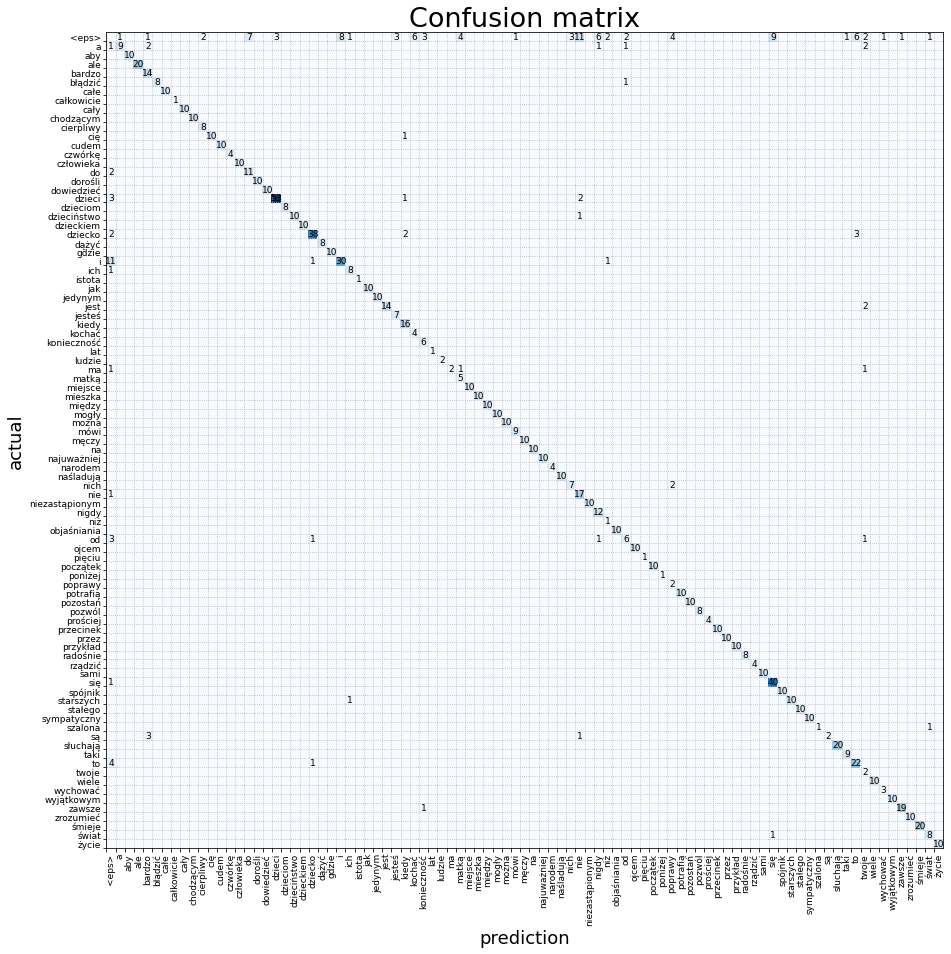

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(
    ax, matrix, labels, title='Confusion matrix', fontsize=9):

    ax.set_xticks([x for x in range(len(labels))])
    ax.set_xticklabels(" ")
    ax.set_yticks([y for y in range(len(labels))])
    ax.set_yticklabels(" ")

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='90', fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    ax.pcolor(matrix[::-1], cmap=plt.cm.Blues)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=3 * fontsize)
    ax.set_xlabel('prediction', fontsize=2 * fontsize)
    ax.set_ylabel('actual', fontsize=2 * fontsize)

    plt.show()

y_true = y_ref
y_pred = y_hyp
class_names = sorted(list(set(y_true).union(set(y_pred))))
cm = confusion_matrix(y_true, y_pred, labels=class_names)
 
fig, ax = plt.subplots(figsize=(15, 15))

plot_confusion_matrix(ax, cm, class_names, fontsize=9)

{'cały', 'lat', 'mieszka', 'całkowicie', 'najuważniej', 'pozwól', 'człowieka', 'na', 'sami', 'objaśniania', 'przykład', 'słuchają', 'prościej', 'wyjątkowym', 'czwórkę', 'zrozumieć', 'aby', 'jak', 'istota', 'pięciu', 'dzieckiem', 'gdzie', 'przecinek', 'śmieje', 'jedynym', 'dorośli', 'można', 'rządzić', 'dowiedzieć', 'ojcem', 'między', 'życie', 'dążyć', 'radośnie', 'ale', 'niezastąpionym', 'potrafią', 'cudem', 'całe', 'ludzie', 'męczy', 'mogły', 'chodzącym', 'pozostań', 'sympatyczny', 'początek', 'poniżej', 'przez', 'wiele', 'miejsce', 'dzieciom', 'spójnik', 'narodem', 'naśladują', 'stałego'}
55


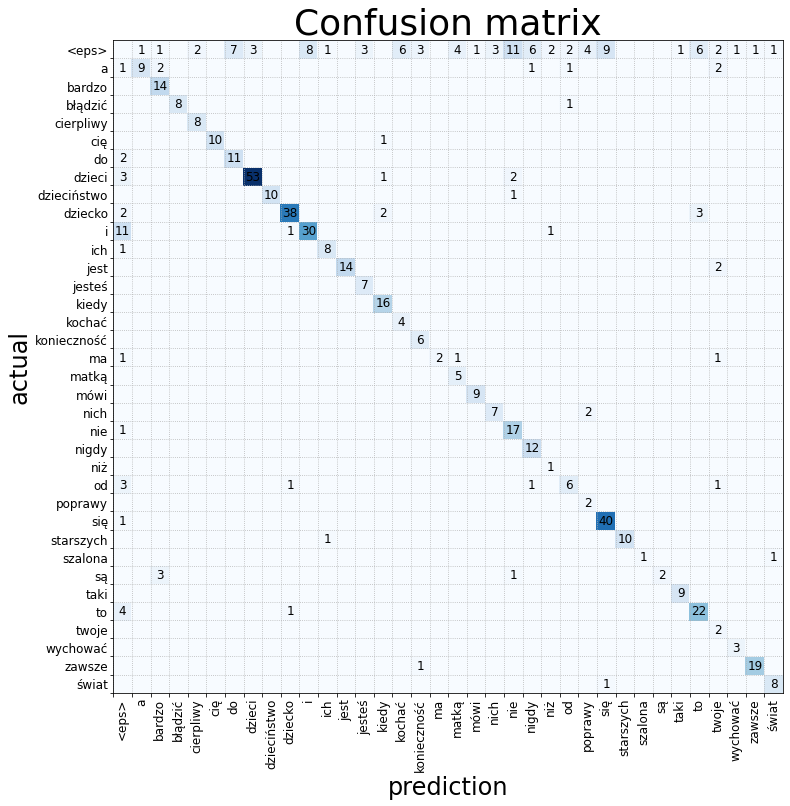

In [ ]:
# Ponieważ jest to mało czytelne - usunę słowa, które nie były mylone ani się nie myliły z innymi słowami

nie_mylone_slowa = set()

cm = confusion_matrix(y_true, y_pred, labels=class_names)

for idx, val in enumerate(cm):
  if val[idx] == sum(cm[idx, :]) and val[idx] == sum(cm[:, idx]):
    nie_mylone_slowa.add(class_names[idx])

print(nie_mylone_slowa)
print(len(nie_mylone_slowa))

# Było takich słów aż 55

y_pred_new = [w for w in y_pred if w not in nie_mylone_slowa]
y_true_new = [w for w in y_true if w not in nie_mylone_slowa]
class_names_new = sorted(list(set(y_true_new).union(set(y_pred_new))))
cm_new = confusion_matrix(y_true_new, y_pred_new, labels=class_names_new)
fig, ax = plt.subplots(figsize=(12, 12))

plot_confusion_matrix(ax, cm_new, class_names_new, fontsize=12)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
# y_true = y_ref
# y_pred = y_hyp
# class_names = sorted(list(set(y_true).union(set(y_pred))))
# cm = confusion_matrix(y_true, y_pred, labels=class_names)

print(classification_report(y_true, y_pred, target_names=class_names))
print(f1_score(y_true, y_pred, average='weighted'))

                precision    recall  f1-score   support

         <eps>       0.00      0.00      0.00        89
             a       0.90      0.56      0.69        16
           aby       1.00      1.00      1.00        10
           ale       1.00      1.00      1.00        20
        bardzo       0.70      1.00      0.82        14
       błądzić       1.00      0.89      0.94         9
          całe       1.00      1.00      1.00        10
    całkowicie       1.00      1.00      1.00         1
          cały       1.00      1.00      1.00        10
     chodzącym       1.00      1.00      1.00        10
     cierpliwy       0.80      1.00      0.89         8
           cię       1.00      0.91      0.95        11
         cudem       1.00      1.00      1.00        10
       czwórkę       1.00      1.00      1.00         4
     człowieka       1.00      1.00      1.00        10
            do       0.61      0.85      0.71        13
       dorośli       1.00      1.00      1.00  

# Podsumowanie

* Kaldi to kombajn, który posiada bardzo dużo użyteczności, ale jego dokumentacja jest wielce enigmatyczna. Gdyby nie ćwiczenia - byłoby to ogarnąć jeszcze ciężej. Ale fakt jest również taki, że Kaldi posiada bardzo dużo przydatnych narzędzi i używanie ich, jak już się wie - co robią - jest całkiem poręczne.
* Przygotowanie modelu języka rozpoznającego przykładowe zdanie jest całkiem proste, jeżeli zrozumie się format i sposób pracy frameworku Kaldi.
* Model rozpoznał 10 razy (`beam-search`) tekst i w sumie wyniki są bardzo zadowalające.
* Dodatkowo robiłem wizualizację błędów (przy użyciu `wer_per_utt_details.pl`) - wypisałem WER całkowity i WER dla każdego ze zdań
* Całkowity WER (`Word Error Rate`) dla wszystki 140 predykcji (14 zdań x 10 predykcji) wyniósł 16.85%, czyli bardzo dobrze
* Następnie dodatkowo policzyłem dodatkowe miary jakości oraz narysowałem macierz konfuzji - wyniki są bardzo zadowalające.
* Ważone F1 dla całego zbioru wyniosło prawie 84%

## Praca domowa

- Na ocenę 3:
    * wybrać jakąś dziedzinę i przygotować przykładowe zdania do niej
    * przygotować gramatykę/model języka rozpoznający przykładowe zdania
    * nagrać kilka przykładowych zdań z mikrofonu
    * dokonać rozpoznawania i oceny przykładowych zdań
    
- Na ocenę 4:
    * wykonać program wizualizacyjny wynik rozpoznawania, na przykład:
        * przeglądanie kraty
        * rysowanie alignmentu (program `lattice-to-ctm-conf`)
        * wizualizacja błędów (wyników programu `wer_per_utt_details.pl`)
        * policzenie dodatkowych miar jakości (F1/ROC detekcji słowa kluczowego, macierz konfuzji słów, itp)

- Na ocenę 5:
    * zrobienie interaktywnej aplikacji wykorzystującej rozpoznawanie mowy, na przykład:
        * wykonanie akcji na podstawie wyniku rozpoznawania
        * parsowanie wyniku rozpoznawania
        * system dialogowy (chatbot)
        * wyszukanie słów kluczowych w kracie/n-best
        * gra